In [1]:
import torch
import numpy as np
from train import NOELSTM 

# Load data
theta = np.load("theta.npy")
omega = np.load("omega.npy")
u = np.load("u.npy")

# Normalize (same as in training)
theta_mean, theta_std = theta.mean(), theta.std()
omega_mean, omega_std = omega.mean(), omega.std()
u_mean, u_std = u.mean(), u.std()

theta_norm = (theta - theta_mean) / theta_std
omega_norm = (omega - omega_mean) / omega_std
u_norm = (u - u_mean) / u_std

# Reuse the same sequence function
def create_sequences(theta, omega, u, seq_len):
    X, Y = [], []
    for i in range(len(theta) - seq_len):
        x_seq = np.stack([theta[i:i+seq_len], omega[i:i+seq_len], u[i:i+seq_len]], axis=1)
        y_target = [theta[i+seq_len], omega[i+seq_len]]
        X.append(x_seq)
        Y.append(y_target)
    return np.array(X), np.array(Y)

sequence_length = 10

X, Y = create_sequences(theta_norm, omega_norm, u_norm, sequence_length)

# Tensor conversion
X_tensor = torch.tensor(X).double()
Y_tensor = torch.tensor(Y).double()

# Split: 80% train, 20% val
n = len(X_tensor)
train_end = int(0.8 * n)
val_end = int(0.9 * n)

Xtrain_tensor = X_tensor[:train_end]
Ytrain_tensor = Y_tensor[:train_end]

Xval_tensor = X_tensor[train_end:]
Yval_tensor = Y_tensor[train_end:]

# Load trained model
model = NOELSTM(input_size=3, hidden_size=64, num_layers=1, output_size=2)  # Adjust config
model.load_state_dict(torch.load("model_lilac-sweep-13.pt", map_location=torch.device("cpu")))
model = model.to("cpu")
model.eval()

# Run predictions
with torch.no_grad():
    train_pred = model(Xtrain_tensor).numpy()
    val_pred = model(Xval_tensor).numpy()

# Unnormalize predictions and ground truths
def unnormalize(preds):
    preds_unnorm = np.empty_like(preds)
    preds_unnorm[:, 0] = preds[:, 0] * theta_std + theta_mean
    preds_unnorm[:, 1] = preds[:, 1] * omega_std + omega_mean
    return preds_unnorm

train_pred = unnormalize(train_pred)
val_pred = unnormalize(val_pred)

Ytrain_final = unnormalize(Ytrain_tensor.numpy())
Yval = unnormalize(Yval_tensor.numpy())

# Metrics
def print_metrics(pred, true, name="Set"):
    rms = np.mean((pred - true)**2)**0.5
    print(f'{name} RMS: {rms:.5f} radians')
    print(f'{name} RMS: {rms / (2*np.pi) * 360:.2f} degrees')
    print(f'{name} NRMS: {rms / np.std(true) * 100:.2f} %')

print("\n=== Final Evaluation (Theta Only) ===")
print_metrics(train_pred[:, 0], Ytrain_final[:, 0], "Train")
print_metrics(val_pred[:, 0], Yval[:, 0], "Validation")



=== Final Evaluation (Theta Only) ===
Train RMS: 0.00080 radians
Train RMS: 0.05 degrees
Train NRMS: 0.17 %
Validation RMS: 0.00116 radians
Validation RMS: 0.07 degrees
Validation NRMS: 0.23 %


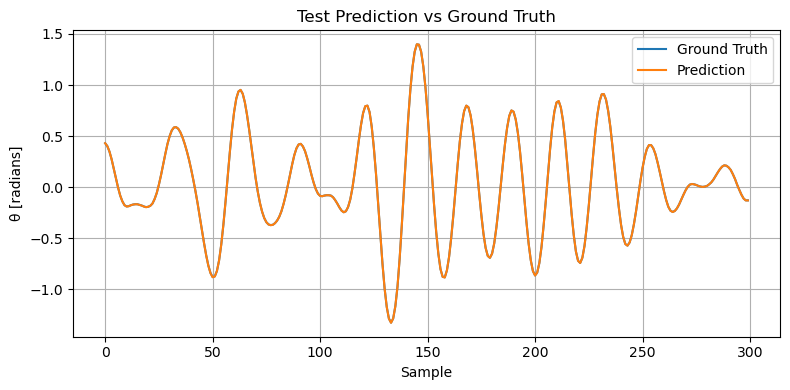

In [2]:
from matplotlib import pyplot as plt 

plt.figure(figsize=(8, 4))
plt.plot(theta[-300:], label='Ground Truth')
plt.plot(val_pred[-300:, 0], label='Prediction')
plt.title('Test Prediction vs Ground Truth')
plt.xlabel('Sample')
plt.ylabel('θ [radians]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [3]:
# Load trained model
model = NOELSTM(input_size=3, hidden_size=64, num_layers=1, output_size=2)  # Adjust config
model.load_state_dict(torch.load("model_whole-forest-45_finetuned.pt", map_location=torch.device("cpu")))
model = model.to("cpu")
model.eval()

# Run predictions
with torch.no_grad():
    train_pred = model(Xtrain_tensor).numpy()
    val_pred = model(Xval_tensor).numpy()

# Unnormalize predictions and ground truths
def unnormalize(preds):
    preds_unnorm = np.empty_like(preds)
    preds_unnorm[:, 0] = preds[:, 0] * theta_std + theta_mean
    preds_unnorm[:, 1] = preds[:, 1] * omega_std + omega_mean
    return preds_unnorm

train_pred = unnormalize(train_pred)
val_pred = unnormalize(val_pred)

Ytrain_final = unnormalize(Ytrain_tensor.numpy())
Yval = unnormalize(Yval_tensor.numpy())

# Metrics
def print_metrics(pred, true, name="Set"):
    rms = np.mean((pred - true)**2)**0.5
    print(f'{name} RMS: {rms:.5f} radians')
    print(f'{name} RMS: {rms / (2*np.pi) * 360:.2f} degrees')
    print(f'{name} NRMS: {rms / np.std(true) * 100:.2f} %')

print("\n=== Final Evaluation (Theta Only) ===")
print_metrics(train_pred[:, 0], Ytrain_final[:, 0], "Train")
print_metrics(val_pred[:, 0], Yval[:, 0], "Validation")


=== Final Evaluation (Theta Only) ===
Train RMS: 0.00038 radians
Train RMS: 0.02 degrees
Train NRMS: 0.08 %
Validation RMS: 0.00075 radians
Validation RMS: 0.04 degrees
Validation NRMS: 0.15 %


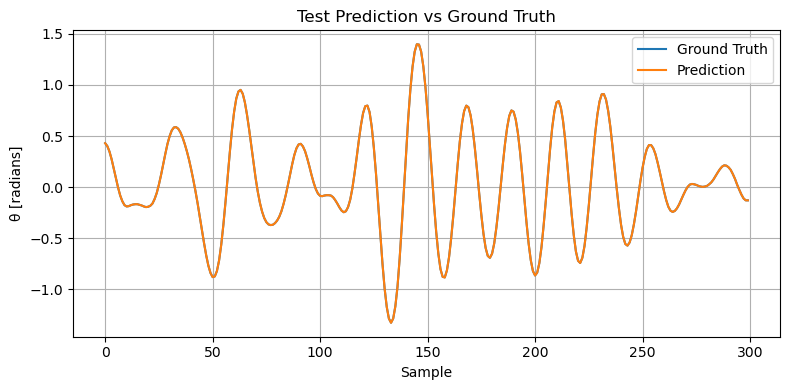

In [4]:
from matplotlib import pyplot as plt 

plt.figure(figsize=(8, 4))
plt.plot(theta[-300:], label='Ground Truth')
plt.plot(val_pred[-300:, 0], label='Prediction')
plt.title('Test Prediction vs Ground Truth')
plt.xlabel('Sample')
plt.ylabel('θ [radians]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
